# <span style="color:red">For NeurIPS 2022 Reviewers</span>

The original version of this notebook is publicly available at [here](https://github.com/anishathalye/obfuscated-gradients/blob/master/inputtransformations/crop.ipynb).

The first part remains unchanged, please feel free to scroll down.

**<span style="color:red">The second part is our new <a href="#ablation">Ablation Study</a> showing that PGD already works without EOT.</span>**

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings('ignore', message=r'Passing', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import inceptionv3
from utils import *
from defense import *

In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole
EPSILON = 8.0/255.0

In [4]:
lower = np.clip(orig-EPSILON, 0, 1)
upper = np.clip(orig+EPSILON, 0, 1)

# Classifier

In [5]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

In [6]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

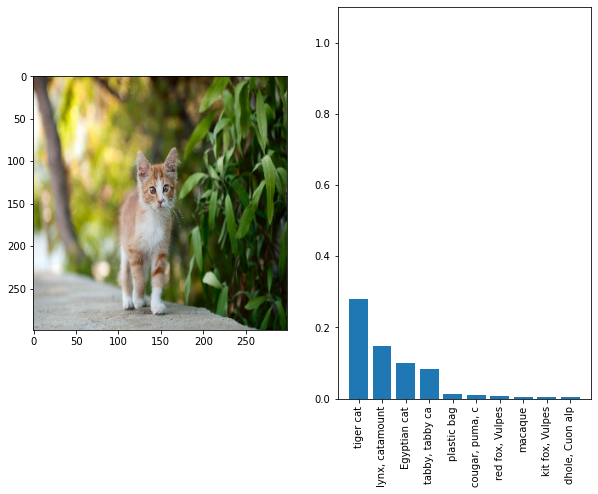

In [7]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [8]:
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
grad, = tf.gradients(loss, x)

In [9]:
# PGD

LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, p = sess.run([grad, preds], {x: adv})
    print('step %d, pred=%d' % (i, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, lower, upper)

step 0, pred=282
step 1, pred=277
step 2, pred=231
step 3, pred=272
step 4, pred=263
step 5, pred=282
step 6, pred=263
step 7, pred=924
step 8, pred=924
step 9, pred=924


In [10]:
cropped_x = defend(x_expanded)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_x)

In [11]:
cropped_probs = tf.nn.softmax(cropped_logits)
cropped_classify = make_classify(sess, x, cropped_probs)

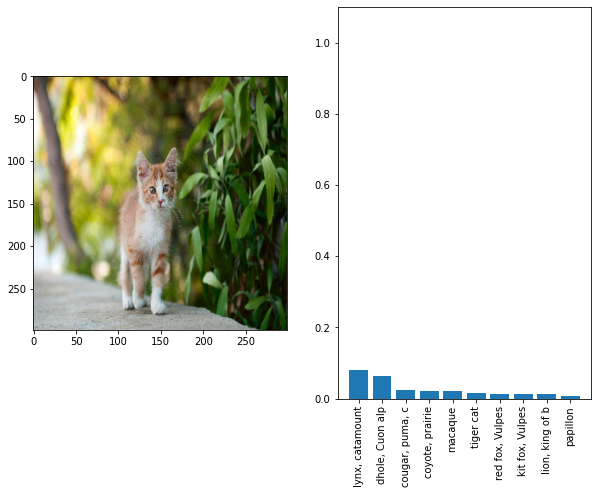

In [12]:
cropped_classify(adv, target_class=TARGET)

# Attack

Using EOT.

In [13]:
ENSEMBLE_SIZE = 30 # larger sample size -> better gradient estimate

In [14]:
ensemble_xs = tf.concat([defend(x_expanded) for _ in range(ENSEMBLE_SIZE)], axis=0)
ensemble_logits, ensemble_preds = inceptionv3.model(sess, ensemble_xs)

In [15]:
ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (ensemble_logits.shape[0], 1))
ensemble_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels))
ensemble_grad, = tf.gradients(ensemble_loss, x)

In [16]:
# PGD

LR = 0.1

adv = np.copy(orig)
for i in range(50):
    g, p = sess.run([ensemble_grad, ensemble_preds], {x: adv})
    if i % 10 == 0:
        print('step %d, preds=%s' % (i, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, lower, upper)

step 0, preds=[278 287 287 287 287 287 287 287 287 287 277 287 287 287 287 287 287 287
 285 287 285 287 287 287 287 287 287 287 287 287]
step 10, preds=[924 263 157 218 924 924 282 924 924 282 924 157 282 924 924 282 282 157
 924 282 282 274 157 282 924 924 728 157 728 157]
step 20, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]
step 30, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]
step 40, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]


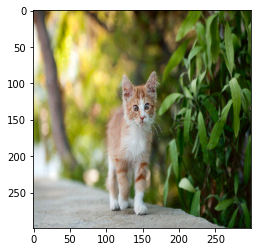

In [17]:
plt.imshow(adv)

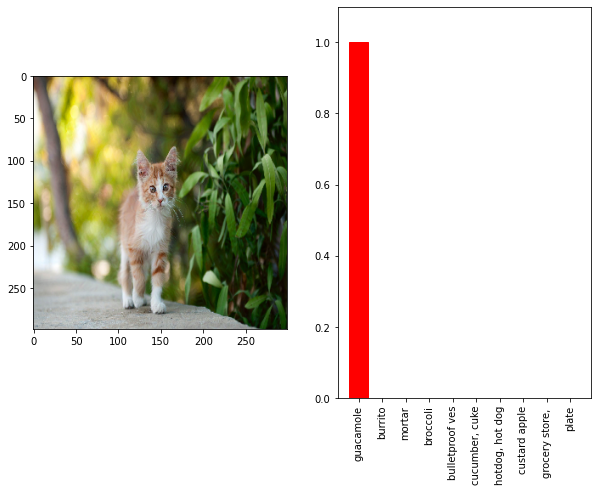

In [18]:
cropped_classify(adv, target_class=TARGET)

<a id='ablation'></a>
# <span style="color:red">Our New Ablation Study</span>

The above example uses the following parameters:

```
ENSEMBLE_SIZE: 30
Learning Rate: 0.1
PGD Steps    : 50
```

Now, we change these parameters to:

```
ENSEMBLE_SIZE: 1
Learning Rate: 0.1
PGD Steps    : 50
```

**<span style="color:red">Below, we show that the new setting (without EOT) still breaks the defense.</span>**

We first reconstruct the computation graph with ENSEMBLE_SIZE = 1

In [19]:
ENSEMBLE_SIZE = 1

ensemble_xs = tf.concat([defend(x_expanded) for _ in range(ENSEMBLE_SIZE)], axis=0)
ensemble_logits, ensemble_preds = inceptionv3.model(sess, ensemble_xs)

ensemble_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (ensemble_logits.shape[0], 1))
ensemble_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ensemble_logits, labels=ensemble_labels))
ensemble_grad, = tf.gradients(ensemble_loss, x)

In [23]:
# PGD

LR = 0.1

adv = np.copy(orig)
for i in range(50):
    g, p = sess.run([ensemble_grad, ensemble_preds], {x: adv})
    if i % 10 == 0:
        print('step %d, preds=%s' % (i, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, lower, upper)

step 0, preds=[287]
step 10, preds=[291]
step 20, preds=[924]
step 30, preds=[924]
step 40, preds=[924]


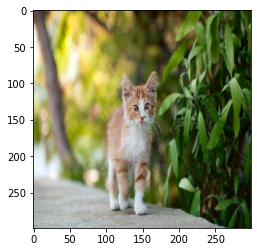

In [24]:
plt.imshow(adv)

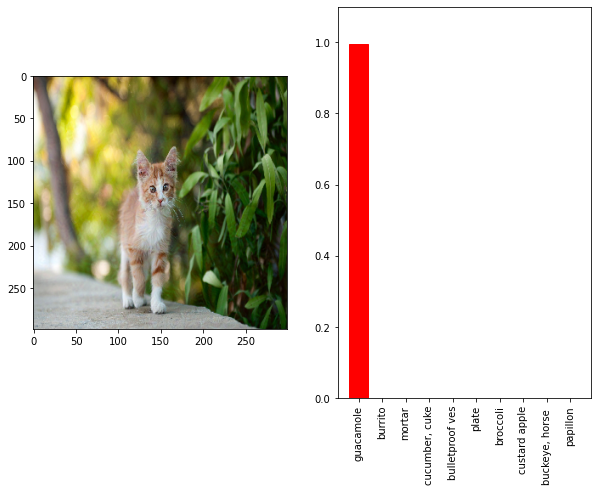

In [25]:
cropped_classify(adv, target_class=TARGET)